In [49]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
from mlxtend import plotting
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score,mean_squared_error, r2_score, recall_score, precision_score, confusion_matrix, classification_report, roc_curve, plot_roc_curve, precision_recall_curve
from sklearn import metrics
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
test_set = pd.read_csv("test_set.csv")
train_set = pd.read_csv("train_set.csv")

In [3]:
y_test = test_set["DEATH_EVENT"]
y_train = train_set["DEATH_EVENT"]
X_train = train_set.drop("DEATH_EVENT", axis=1)
X_test = test_set.drop("DEATH_EVENT", axis=1)

In [4]:
train_set["DEATH_EVENT"].value_counts(normalize = True)
#NIEZBALANSOWANY DATASET

0    0.677824
1    0.322176
Name: DEATH_EVENT, dtype: float64

# LOGISTIC REGRESSION

#### LOGISTIC REGRESSION FEATURE IMPORTANCE

In [6]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
importance = model.coef_[0]

In [11]:
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
print(X_train.columns)

Feature: 0, Score: 0.04822
Feature: 1, Score: 0.00012
Feature: 2, Score: 0.00011
Feature: 3, Score: 0.00064
Feature: 4, Score: -0.07118
Feature: 5, Score: 0.00053
Feature: 6, Score: -0.00000
Feature: 7, Score: 0.00606
Feature: 8, Score: 0.01247
Feature: 9, Score: -0.00091
Feature: 10, Score: -0.00058
Feature: 11, Score: -0.02015
Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time'],
      dtype='object')


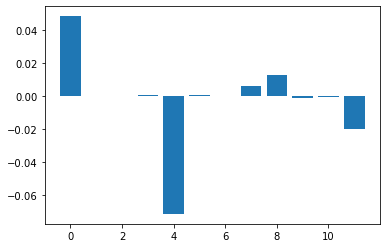

In [9]:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### FEATURES SELECTION

In [12]:
X_train_clip= X_train[['age', 'ejection_fraction', 'serum_creatinine','serum_sodium', 'time']]
X_test_clip= X_test[['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']]

In [13]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_clip)
X_test_sc = sc.transform(X_test_clip)

In [14]:
param_grid = {'class_weight': ["balanced"],
              'penalty' : ['l1','l2','elasticnet', 'none'],
              'C':[0.01,0.1,0.2,0.3,0.4,0.5],
              'solver'  : ['liblinear','newton-cg', 'lbfgs']
             }

In [15]:
model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring = 'recall')
grid_search.fit(X_train_sc, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']},
             scoring='recall')

In [17]:
best_param_no = grid_search.best_index_ 
print('Best parameters:', grid_search.best_params_, '(no. {0})'.format(best_param_no))
print('Best parameters score:', grid_search.best_score_)

Best parameters: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} (no. 3)
Best parameters score: 0.8316666666666667


In [18]:
best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test_sc)
y_score = best_log_reg.predict_proba(X_test_sc)[:, 1]

In [19]:
print("Confusion matrix:", confusion_matrix(y_test, y_pred))
print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred, target_names = ['Heart Not Failed','Heart Failed']))

Confusion matrix: [[32  9]
 [ 4 15]]
Raport klasyfikacyjny: 
                   precision    recall  f1-score   support

Heart Not Failed       0.89      0.78      0.83        41
    Heart Failed       0.62      0.79      0.70        19

        accuracy                           0.78        60
       macro avg       0.76      0.78      0.76        60
    weighted avg       0.81      0.78      0.79        60



In [20]:
print("-----Test set scores for Logistic Regression-----") 
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(metrics.recall_score(y_test, y_pred)))
print("F1_score: {:.4f}".format(metrics.f1_score(y_test, y_pred)))
print("Roc_auc_score: {:.4f}".format(roc_auc_score(y_test, y_score)))
print("F-beta: {:.4f}".format(metrics.fbeta_score(y_test, y_pred, beta=2.0)))

-----Test set scores for Logistic Regression-----
Accuracy: 0.7833
Precision: 0.6250
Recall: 0.7895
F1_score: 0.6977
Roc_auc_score: 0.9063
F-beta: 0.7500


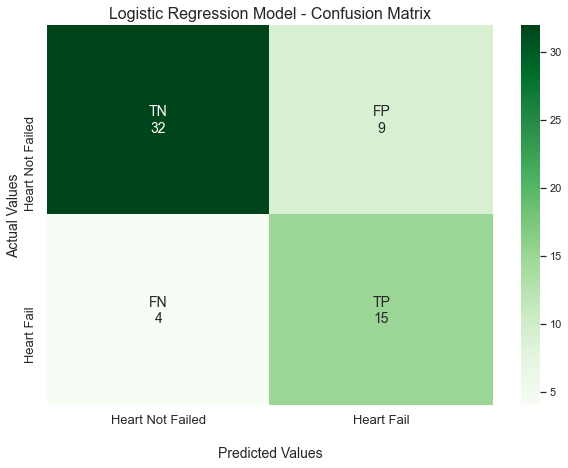

In [21]:
sns.set(rc={"figure.figsize":(10, 7)}) 
cm = confusion_matrix(y_test, y_pred)

group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,  fmt='', cmap='Greens',annot_kws={'size':14})

ax.set_title("Logistic Regression Model - Confusion Matrix", fontsize=16);
ax.set_xlabel('\nPredicted Values',fontsize=14)
ax.set_ylabel('Actual Values',fontsize=14);

ax.xaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)
ax.yaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)


plt.show()

# XGBOOST CLASSIFIER

#### XGBOOST FEATURE IMPORTANCE

In [22]:
xg_clas0 = xgb.XGBClassifier(seed=123)
xg_clas0.fit(X_train, y_train)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

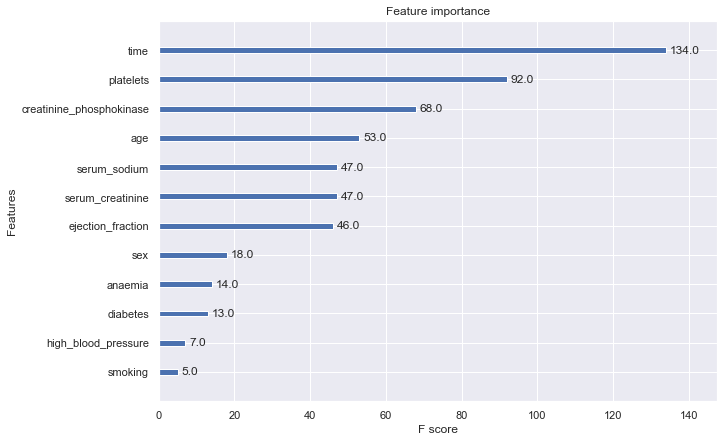

In [25]:
xgb.plot_importance(xg_clas0)

#### FEATURES SELECTION

In [26]:
X_train_clip= X_train[['time', 'age', 'platelets', 'creatinine_phosphokinase', 'serum_creatinine']]
X_test_clip= X_test[['time', 'age', 'platelets', 'creatinine_phosphokinase', 'serum_creatinine']]

In [27]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train_clip)
X_test_sc = sc.transform(X_test_clip)

In [28]:
run_xboost = True

if run_xboost:
    parameter_grid = {
                "scale_pos_weight": [100],
                "objective": ["reg:logistic"],
                 "n_estimators": [10,20,100,200],
                 'max_depth' : [3,4,5, 6, 7, 8],
                 'gamma': [0,0.2, 0.4, 0.8, 1.5]
                 }
    xg_clas_Sc = XGBClassifier(random_state=42)
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(xg_clas_Sc,
                               scoring='roc_auc',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1,
                               n_jobs= -1
                              )

    grid_search.fit(X_train_sc, y_train)
    xg_clas_Sc = grid_search.best_estimator_
    y_pred = xg_clas_Sc.predict(X_test_sc)
    y_score = xg_clas_Sc.predict_proba(X_test_sc)[:, 1]
    
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.8950019728535354
Best parameters: {'gamma': 0.2, 'max_depth': 7, 'n_estimators': 20, 'objective': 'reg:logistic', 'scale_pos_weight': 100}


In [29]:
print("Confusion matrix:", confusion_matrix(y_test, y_pred))
print("Raport klasyfikacyjny: \n", classification_report(y_test, y_pred,target_names = ['Heart Not Failed','Heart Failed']))

Confusion matrix: [[35  6]
 [ 3 16]]
Raport klasyfikacyjny: 
                   precision    recall  f1-score   support

Heart Not Failed       0.92      0.85      0.89        41
    Heart Failed       0.73      0.84      0.78        19

        accuracy                           0.85        60
       macro avg       0.82      0.85      0.83        60
    weighted avg       0.86      0.85      0.85        60



In [30]:
print("-----Test set scores for XGBoostClassifier-----") 
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Precision: {:.4f}".format(metrics.precision_score(y_test, y_pred)))
print("Recall: {:.4f}".format(metrics.recall_score(y_test, y_pred)))
print("F1_score: {:.4f}".format(metrics.f1_score(y_test, y_pred)))
print("Roc_auc_score: {:.4f}".format(roc_auc_score(y_test, y_score)))
print("F-beta: {:.4f}".format(metrics.fbeta_score(y_test, y_pred, beta=2.0)))

-----Test set scores for XGBoostClassifier-----
Accuracy: 0.8500
Precision: 0.7273
Recall: 0.8421
F1_score: 0.7805
Roc_auc_score: 0.8723
F-beta: 0.8163


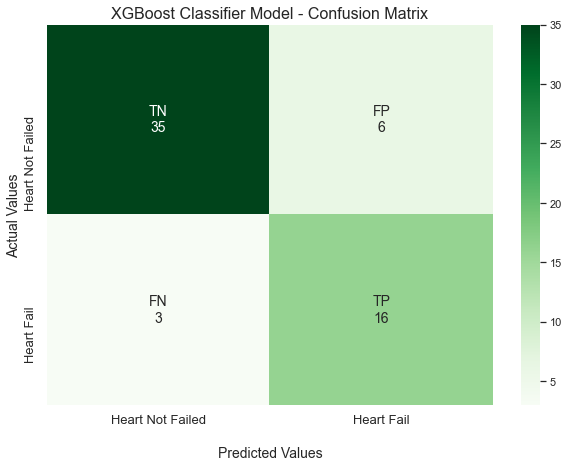

In [31]:
sns.set(rc={"figure.figsize":(10, 7)}) 
cm = confusion_matrix(y_test, y_pred)

group_names = ['TN','FP','FN','TP']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cm, annot=labels,  fmt='', cmap='Greens',annot_kws={'size':14})

ax.set_title("XGBoost Classifier Model - Confusion Matrix", fontsize=16);
ax.set_xlabel('\nPredicted Values',fontsize=14)
ax.set_ylabel('Actual Values',fontsize=14);

ax.xaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)
ax.yaxis.set_ticklabels(["Heart Not Failed","Heart Fail"],fontsize=13)


plt.show()

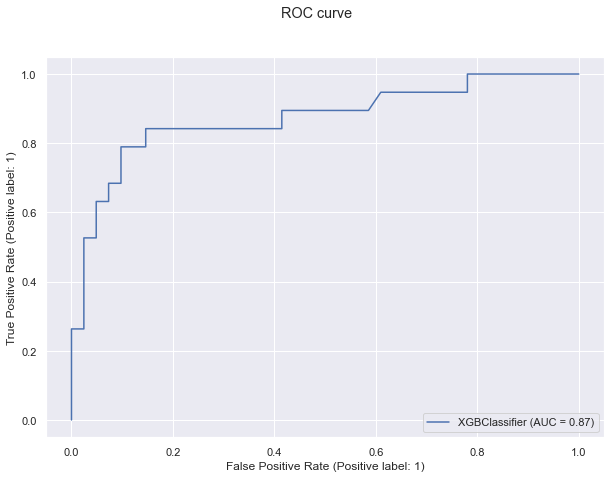

In [48]:
sns.set(rc={"figure.figsize":(10, 7)}) 
fig = plot_roc_curve(xg_clas_Sc,X_test_sc,y_test)
fig.figure_.suptitle("ROC curve")
plt.show() 

Text(0, 0.5, 'Precision')

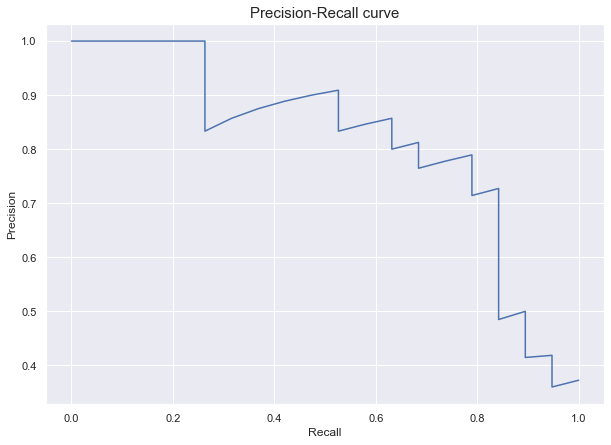

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.figure(figsize=(10, 7))
plt.plot(recall, precision)
plt.title("Precision-Recall curve",fontsize=15)
plt.xlabel("Recall")
plt.ylabel("Precision")